In [28]:
#load all the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [29]:
#load the data
song_data = pd.read_csv("spotify_song.csv")
print(song_data.head())

   Unnamed: 0                track_id  \
0           0  6f807x0ima9a1j3VPbc7VN   
1           1  0r7CVbZTWZgbTCYdfa2P31   
2           2  1z1Hg7Vb0AhHDiEmnDE79l   
3           3  75FpbthrwQmzHlBJLuGdC7   
4           4  1e8PAfcKUYoKkxPhrHqw4x   

                                          track_name      track_artist  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...        Ed Sheeran   
1                    Memories - Dillon Francis Remix          Maroon 5   
2                    All the Time - Don Diablo Remix      Zara Larsson   
3                  Call You Mine - Keanu Silva Remix  The Chainsmokers   
4            Someone You Loved - Future Humans Remix     Lewis Capaldi   

   track_popularity          track_album_id  \
0                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1                67  63rPSO264uRjW1X5E6cWv6   
2                70  1HoSmj2eLcsrR0vE9gThr4   
3                60  1nqYsOef1yKKuGOVchbsk6   
4                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                         

In [30]:
song_data.shape

(32833, 24)

In [31]:
#Check for missing values
song_data.isnull().sum()

Unnamed: 0                  0
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [32]:
#Drop the missing values
clean_song_data = song_data.dropna()

#check for missing values again
clean_song_data.isnull().sum()

Unnamed: 0                  0
track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [33]:
#Check for any duplicated items
clean_song_data.duplicated()

#drop any duplicates
clean_song_data.drop_duplicates(inplace=True)

C:\Users\maria\AppData\Local\Temp\ipykernel_25396\1269268935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_song_data.drop_duplicates(inplace=True)


In [34]:
#drop any columns that we dim irrelevant for the recommendation system
cleaned_song_data = clean_song_data.drop(['Unnamed: 0'], axis=1)

In [35]:
#print the names of the columns
print(cleaned_song_data.columns)

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')


In [36]:
# Import necessary library
from scipy.stats.mstats import winsorize

#It applies winsorization to the dataset, replacing outliers in 
#specified columns with values at the 5th and 95th percentiles.
# Define a function to winsorize outliers

def handle_outliers_winsorize(df):
    # Apply winsorization to each column containing outliers
    columns_with_outliers = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'key', 'mode']
    for col in columns_with_outliers:
        cleaned_song_data.loc[:, col] = winsorize(cleaned_song_data[col], limits=[0.05, 0.05])  # Winsorize at the 5th and 95th percentiles
    return cleaned_song_data

# Apply winsorization to your dataset
cleaned_song_data = handle_outliers_winsorize(cleaned_song_data)
cleaned_song_data.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,6/14/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.972,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),12/13/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),7/5/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,7/19/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),3/5/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [37]:
# Feature selection based on recommended features
features_for_modeling = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode', 'key']

In [38]:
# Convert 'track_album_release_date' to datetime and extract the year
cleaned_song_data['track_album_release_date'] = pd.to_datetime(cleaned_song_data['track_album_release_date'], errors='coerce', infer_datetime_format=True)
cleaned_song_data['release_year'] = cleaned_song_data['track_album_release_date'].dt.year
features_for_modeling.append('release_year')

C:\Users\maria\AppData\Local\Temp\ipykernel_25396\1182481839.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  cleaned_song_data['track_album_release_date'] = pd.to_datetime(cleaned_song_data['track_album_release_date'], errors='coerce', infer_datetime_format=True)


In [39]:
# Select and normalize features
X = cleaned_song_data[features_for_modeling].fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=features_for_modeling)
X_lstm = X.values.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

In [40]:
# Create a binary target based on 'track_popularity'
popularity_threshold = cleaned_song_data['track_popularity'].quantile(0.75)
y = (cleaned_song_data['track_popularity'] >= popularity_threshold).astype(int)
y = to_categorical(y)  # Convert labels to categorical one-hot encoding


In [41]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

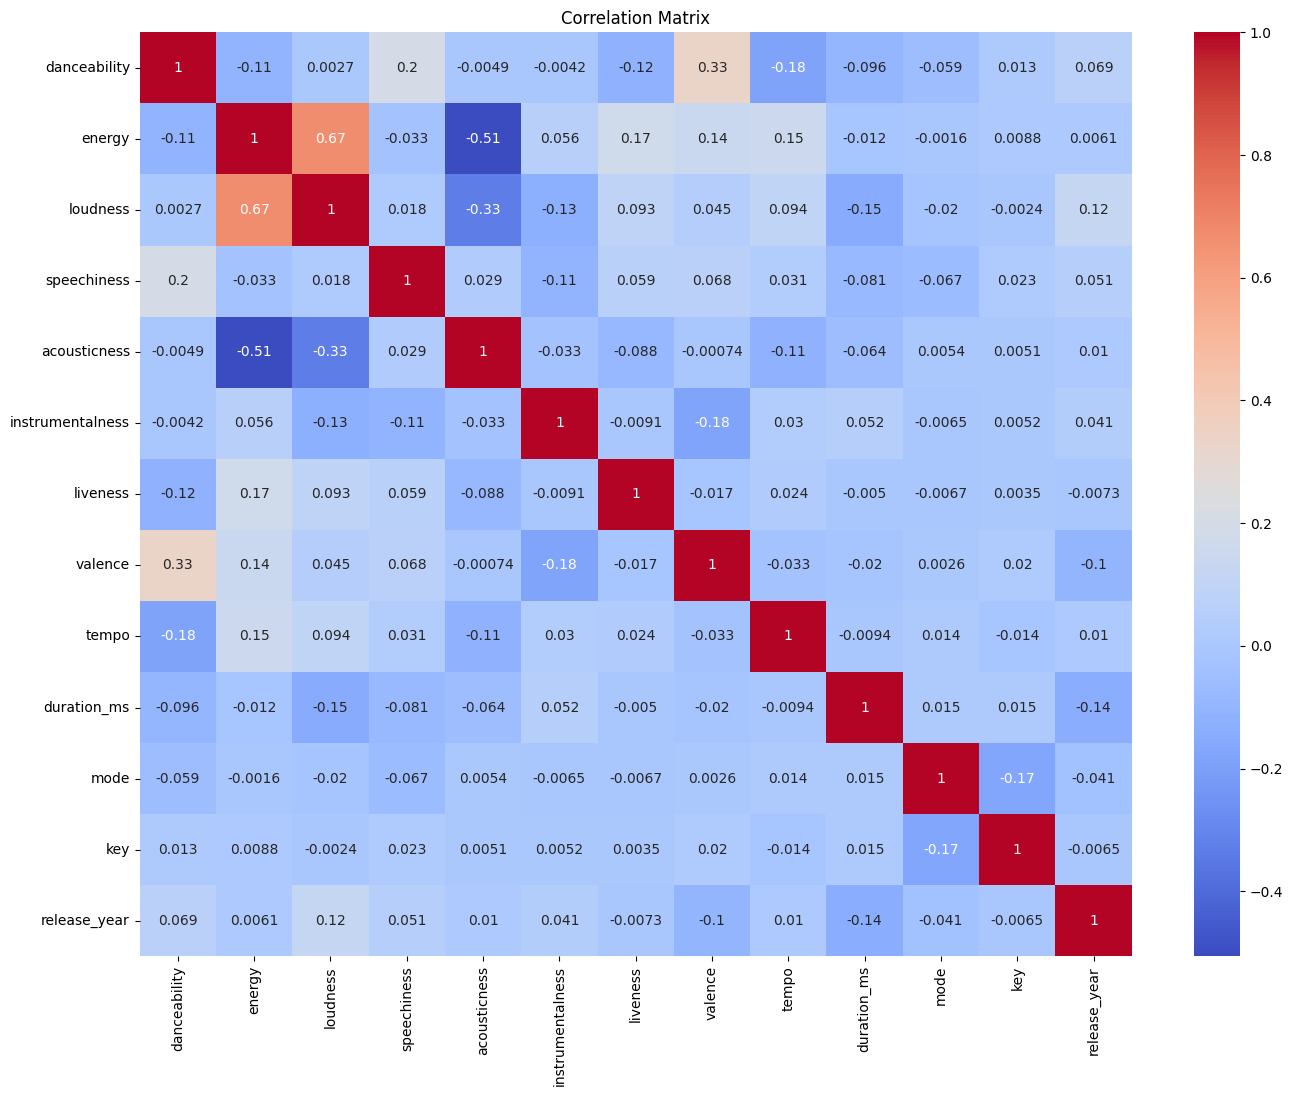

In [42]:
# Created a heatmap to see the correlation between the different features of the data
corr_matrix = X.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [43]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Making predictions on the testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculating metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes)

print(f"Classification Report:\n{classification_report(y_test_classes, y_pred_classes)}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-Score: {f_score}")

# User interaction for song recommendation
input_song_title = input("Enter the title of a song: ").strip().lower()
input_artist = input("Enter the artist of the song: ").strip().lower()

# Normalize data to lower case for case-insensitive matching
cleaned_song_data['track_name_lower'] = cleaned_song_data['track_name'].str.lower()
cleaned_song_data['track_artist_lower'] = cleaned_song_data['track_artist'].str.lower()

# Find the user's song in the dataset
user_song = cleaned_song_data[(cleaned_song_data['track_name_lower'] == input_song_title) & 
                              (cleaned_song_data['track_artist_lower'] == input_artist)]


if not user_song.empty:
    # Predict the likelihood of liking for the dataset used in model training
    probabilities = model.predict(X_lstm)
    cleaned_song_data['predicted_likelihood'] = probabilities[:, 1]
    
    # Calculate cosine similarity for the user's song
    user_song_features = user_song[features_for_modeling].values.reshape(user_song.shape[0], len(features_for_modeling), 1)
    similarities = cosine_similarity(user_song_features.squeeze(), X_lstm.squeeze()).flatten()

    # Exclude the user's input song from the recommendations
    indices_to_exclude = user_song.index
    probabilities[indices_to_exclude, 1] = -np.inf  # Set probabilities to negative infinity for exclusion

    # Filter and sort the DataFrame based on 'predicted_likelihood'
    sorted_indices = np.argsort(-probabilities[:, 1])  # Indices of songs sorted by decreasing likelihood
    top_similarities_indices = sorted_indices[:20]  # Select top 20 to filter duplicates later

    # Ensure the recommendations are unique and do not include the user's song
    top_recommendations = cleaned_song_data.iloc[top_similarities_indices].drop_duplicates(subset=['track_name', 'track_artist'])
    top_recommendations = top_recommendations.head(10)  # Limit to top 10 after removing duplicates
    top_recommendations['similarity'] = similarities[top_recommendations.index]  # Assign similarities to the top recommendations
    
    # Display the top 10 recommendations
    print("Top 10 recommended songs based on predicted likelihood of being 'liked':")
    print(top_recommendations[['track_name', 'track_artist', 'predicted_likelihood', 'similarity']])
else:
    print("Sorry, the input song is not found in the database.")

c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7418 - loss: 0.5784
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7385 - loss: 0.5769
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7447 - loss: 0.5690
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7377 - loss: 0.5756
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7388 - loss: 0.5684
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7451 - loss: 0.5576
Epoch 7/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7374 - loss: 0.5650
Epoch 8/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7377 - loss: 0.5617
Epoch 9/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7428 - loss: 0.5544
Epoch 10/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7416 - loss: 0.5533
Epoch 11/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7386 - loss: 0.5553
Epoch 12/50
821/821 ━━━━━━━━━━━━━━